In [1]:
# Read in the data from the CSV file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

try:
    from skbio.stats.distance import DistanceMatrix, permanova
    SKBIO_AVAILABLE = True
except ImportError:
    SKBIO_AVAILABLE = False


In [2]:
def preprocess_data(df, variables):
    """
    Standardize selected variables and return cleaned DataFrame and scaled array.
    """
    df_clean = df.dropna(subset=variables)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[variables])
    return df_clean, X_scaled


def perform_hierarchical_clustering(X_scaled, method="ward", n_clusters=3):
    """
    Perform hierarchical clustering and return linkage matrix and cluster labels.
    """
    linkage_matrix = linkage(X_scaled, method=method)
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion="maxclust")
    return linkage_matrix, cluster_labels


def plot_dendrogram(linkage_matrix, labels=None):
    """
    Plot a dendrogram from the hierarchical clustering with sample labels.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=labels, ax=ax)
    ax.set_title("Hierarchical Clustering Dendrogram")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Distance")
    plt.tight_layout()
    plt.show()


def compute_mds(X_scaled, metadata_df, n_components=2):
    """
    Compute MDS coordinates from a distance matrix.
    """
    dist_matrix = pairwise_distances(X_scaled, metric="euclidean")
    mds = MDS(
        n_components=n_components,
        dissimilarity="precomputed",
        random_state=42
    )
    coords = mds.fit_transform(dist_matrix)
    cols = [f"MDS{i+1}" for i in range(n_components)]
    mds_df = pd.DataFrame(coords, columns=cols, index=metadata_df.index)
    return dist_matrix, pd.concat([mds_df, metadata_df], axis=1)


def plot_mds_with_clusters(mds_df, label_col="sample"):
    """
    Plot 2D MDS colored by clusters and styled by season.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(
        data=mds_df,
        x="MDS1",
        y="MDS2",
        hue="cluster",
        style="season",
        s=100,
        ax=ax
    )
    for _, row in mds_df.iterrows():
        ax.text(
            row["MDS1"],
            row["MDS2"],
            row[label_col],
            fontsize=7,
            alpha=0.6
        )
    ax.set_title("MDS with Clusters and Sample Labels")
    ax.set_xlabel("MDS1")
    ax.set_ylabel("MDS2")
    ax.legend(title="Cluster / Season", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_mds_3d(mds_df, label_col="sample"):
    """
    Plot 3D MDS with cluster-based coloring.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        mds_df["MDS1"],
        mds_df["MDS2"],
        mds_df["MDS3"],
        c=mds_df["cluster"].astype(int),
        s=70
    )
    for _, row in mds_df.iterrows():
        ax.text(
            row["MDS1"],
            row["MDS2"],
            row["MDS3"],
            row[label_col],
            fontsize=6
        )
    ax.set_xlabel("MDS1")
    ax.set_ylabel("MDS2")
    ax.set_zlabel("MDS3")
    ax.set_title("3D MDS with Clusters and Sample Labels")
    plt.tight_layout()
    plt.show()

def run_permanova(dist_matrix, metadata_df, group_col, permutations=999):
    """
    Perform PERMANOVA on a distance matrix and metadata.

    - dist_matrix: 2D numpy array of pairwise distances.
    - metadata_df: DataFrame containing grouping column.
    - group_col: name of the column in metadata_df to group by.
    - permutations: number of permutations (default: 999).
    """
    if not SKBIO_AVAILABLE:
        raise ImportError("scikit-bio is required for PERMANOVA")

    # replace NaNs
    if np.isnan(dist_matrix).any():
        mean_val = np.nanmean(dist_matrix)
        dist_matrix = np.nan_to_num(dist_matrix, nan=mean_val)

    # symmetrize and zero diagonal
    dist_matrix = (dist_matrix + dist_matrix.T) / 2
    np.fill_diagonal(dist_matrix, 0)
    dist_matrix = np.round(dist_matrix, 12)

    # build DistanceMatrix without strict validation
    dm = DistanceMatrix(dist_matrix,
                        ids=metadata_df.index.astype(str).tolist(),
                        validate=False)

    # extract grouping as plain list
    if group_col not in metadata_df:
        raise KeyError(f"Column '{group_col}' not found in metadata")
    grouping = metadata_df[group_col].tolist()

    # run PERMANOVA
    result = permanova(dm, grouping, permutations=permutations)
    return result


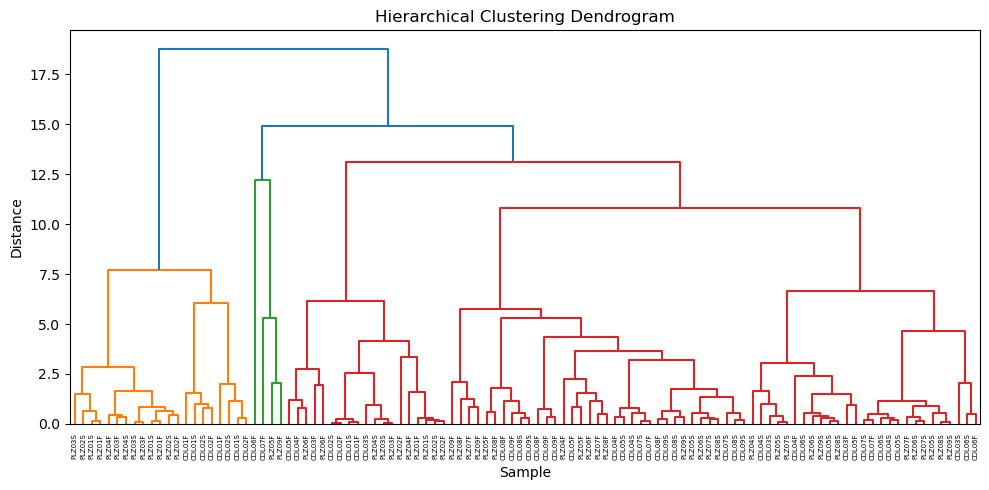

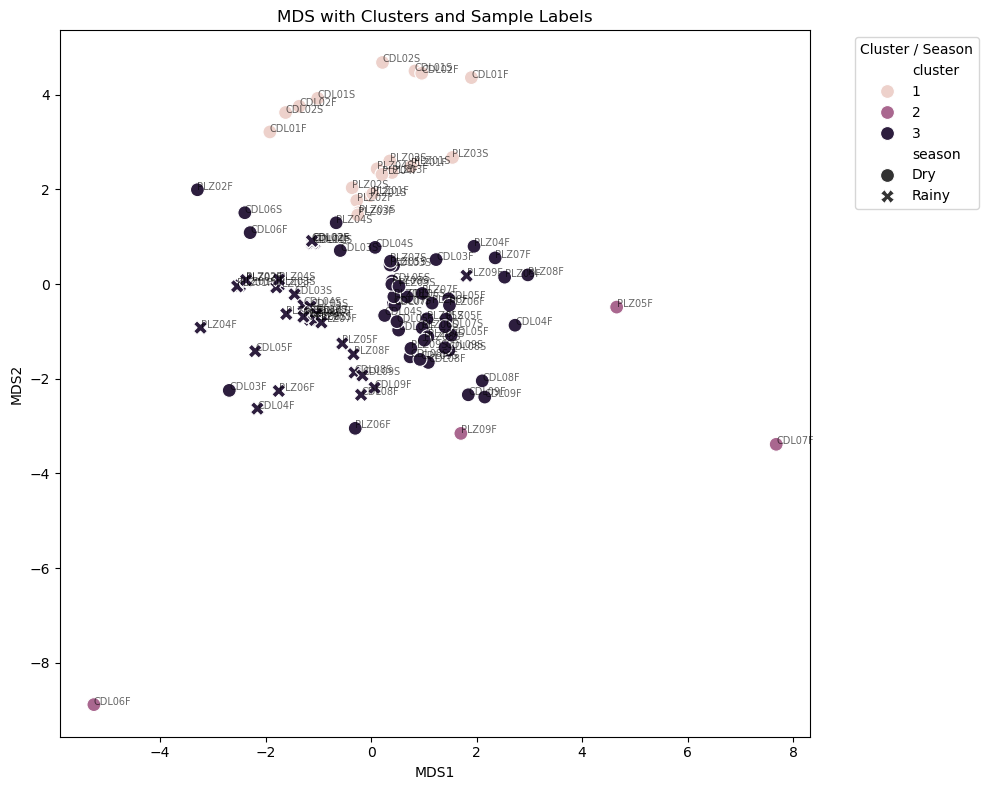

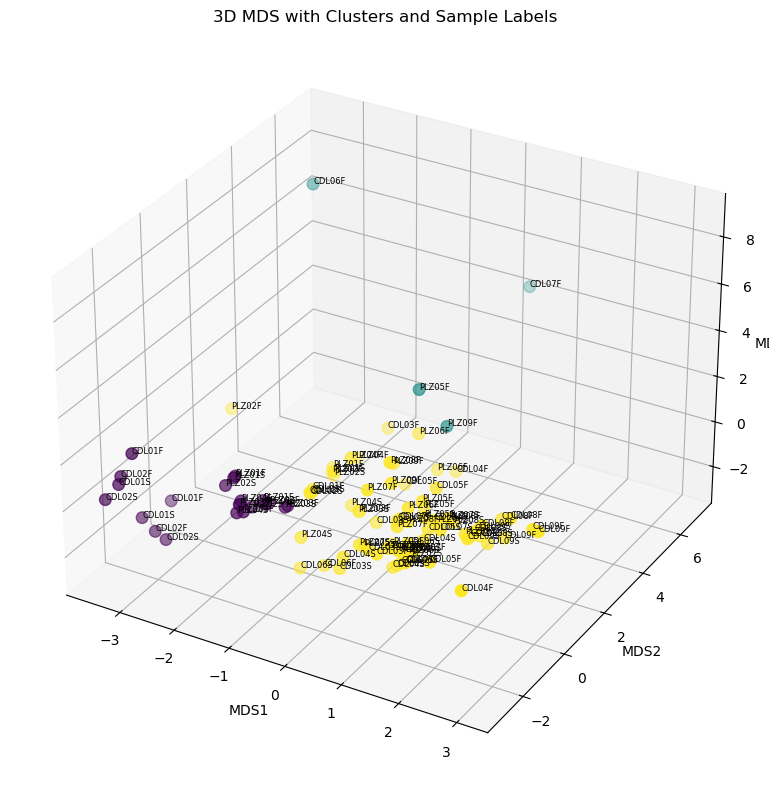

In [3]:
if __name__ == "__main__":
    data_path = "../data/Terminos_lagoon_TA_DIC_2023_RawData.csv"
    df = pd.read_csv(data_path)

    selected_vars = [
        "dic_micromol_kg",
        "ta_micromol_kg",
        "sal_psu",
        "temp_c",
        "do_mg_l",
        "chlorophy_microg_l",
        "turbidity_fnu",
    ]

    df_clean, X_scaled = preprocess_data(df, selected_vars)

    linkage_matrix, clusters = perform_hierarchical_clustering(
        X_scaled,
        n_clusters=3
    )
    df_clean["cluster"] = clusters

    plot_dendrogram(linkage_matrix, labels=df_clean["sample"].values)

    dist2d, mds2_df = compute_mds(
        X_scaled,
        df_clean[["season", "estuary", "sample", "cluster"]],
        n_components=2
    )
    plot_mds_with_clusters(mds2_df)

    dist3d, mds3_df = compute_mds(
        X_scaled,
        df_clean[["season", "estuary", "sample", "cluster"]],
        n_components=3
    )
    plot_mds_3d(mds3_df)

    if SKBIO_AVAILABLE:
        result = run_permanova(dist2d, mds2_df, group_col="cluster")
        print("PERMANOVA Results:")
        print(result)
